# `micrograd`: construction d'une bibliothèque de rétropropagation du gradient (partie 2)

Ce notebook est dérivé du travail d'[Andrej Karpathy](https://karpathy.ai/) et reprend pas à pas les étapes exposées dans sa première séance de cours sur la construction d'un outil en Python pour le calcul du gradient et sa propagation arrière:

[The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

Voici les ressources originales associées à la vidéo youtube d'Andrej:

- micrograd on github: https://github.com/karpathy/micrograd
- notebook original: https://github.com/karpathy/nn-zero-to-hero/tree/master/lectures/micrograd
- exercices: https://colab.research.google.com/drive/1FPTx1RXtBfc4MaTkf7viZZD4U2F9gtKN?usp=sharing

In [1]:
# Imports de la librairie standard Python
import math
# Imports spécifiques (doivent être présent dans l'environnement Python de ce notebook)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph

## Amélioration de classe `Value`

### Rappels

In [2]:
class Value:
  
    def __init__(self, data, children=(), op='', label=''):
        self.data = data
        self._prev = set(children)
        self._op = op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label}, grad={self.grad})"

    def __add__(self, other):
        out = self.__class__(self.data + other.data, children=(self, other), op='+')
        def _backward():
            self.grad = out.grad 
            other.grad = out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = self.__class__(self.data * other.data, children=(self, other), op='*')
        def _backward():
            self.grad = other.data * out.grad 
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, children=(self,), op='tanh')
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

In [3]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'

In [4]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

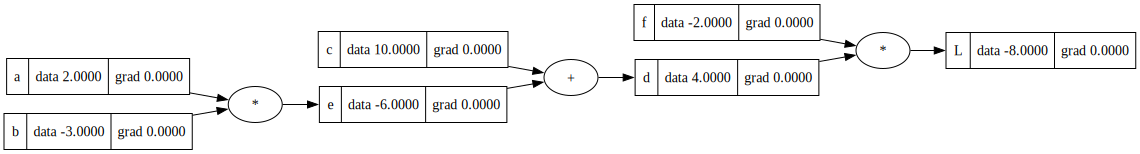

In [5]:
draw_dot(L)

In [6]:
L.backward()

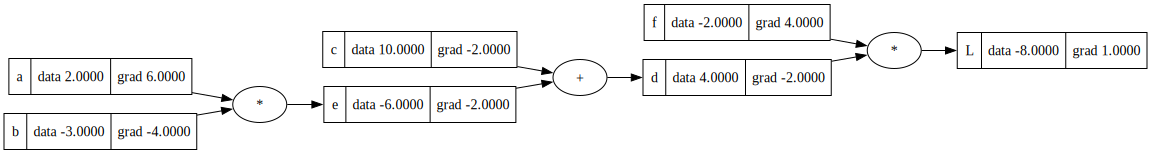

In [7]:
draw_dot(L)

### Problème de non-cumul des gradients

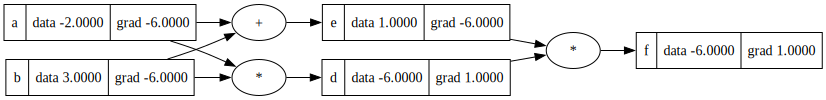

In [8]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

Dans ce graphe un peu particulier, les valeurs des gradients pour $a$ et $b$ sont fausses. En effet, il faut cumuler ces gradients lors du calcul, voir [multivariable case (chain rule)](https://en.wikipedia.org/wiki/Chain_rule#Multivariable_case).

In [9]:
class Value:
  
    def __init__(self, data, children=(), op='', label=''):
        self.data = data
        self._prev = set(children)
        self._op = op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label}, grad={self.grad})"

    def __add__(self, other):
        out = self.__class__(self.data + other.data, children=(self, other), op='+')
        def _backward():
            self.grad += out.grad 
            other.grad += out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = self.__class__(self.data * other.data, children=(self, other), op='*')
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, children=(self,), op='tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

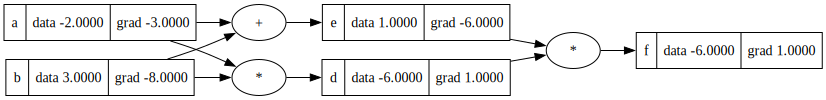

In [10]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'
f.backward()

draw_dot(f)

### Ajout de nouvelles fonctions

#### Support des constantes

Pour `__add__` et `__mul__`, on ajoute une instruction permettant d'utiliser des constructions comme `b = a + 1`, en transformant `1` en `Value(1.0)`.

In [11]:
class Value:
  
    def __init__(self, data, children=(), op='', label=''):
        self.data = data
        self._prev = set(children)
        self._op = op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)  # a + 1
        out = self.__class__(self.data + other.data, children=(self, other), op='+')
        def _backward():
            self.grad += out.grad 
            other.grad += out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)  # a * 1
        out = self.__class__(self.data * other.data, children=(self, other), op='*')
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, children=(self,), op='tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

#### Commutativité

Pour `__add__` et `__mul__`, support indiférencié de `a + 1` ou `1 + a`, en déclarant les méthodes [`__radd__`](https://docs.python.org/3.12/reference/datamodel.html#object.__radd__) et [`__rmul__`](https://docs.python.org/3.12/reference/datamodel.html#object.__rmul__).

In [12]:
def __rmul__(self, other): # other * self
    return self * other
Value.__rmul__ = __rmul__

In [13]:
def __radd__(self, other): # other * self
    return self + other
Value.__radd__ = __radd__

#### Implémentation de l'exponentielle, de la négation, de la puissance et de la division

In [14]:
class Value:
  
    def __init__(self, data, children=(), op='', label=''):
        self.data = data
        self._prev = set(children)
        self._op = op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)  # a + 1
        out = self.__class__(self.data + other.data, children=(self, other), op='+')
        def _backward():
            self.grad += out.grad 
            other.grad += out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)  # a * 1
        out = self.__class__(self.data * other.data, children=(self, other), op='*')
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, children=(self,), op='tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __radd__(self, other): # other * self
        return self + other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
  
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
          self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

#### Exemples d'utilisation

In [15]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

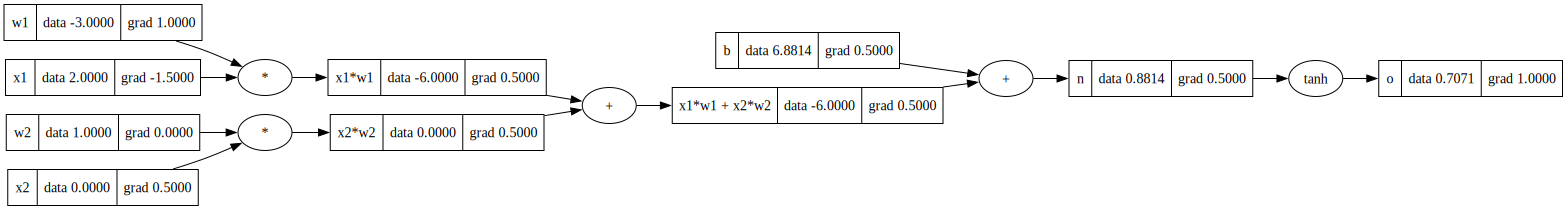

In [16]:
draw_dot(o)

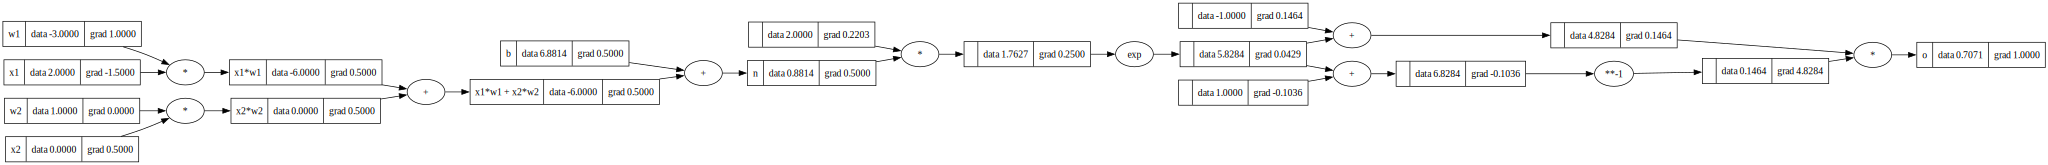

In [17]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [18]:
print(o.data)

0.7071067811865477


#### Expression équivalente avec Pytorch

Pour que cette section fonctionne, il est nécessaire que PyTorch soit installé sur la machine faisant tourner Jupyter (`pip install torch`).

In [19]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [20]:
print(x1)

tensor([2.], dtype=torch.float64, requires_grad=True)


In [21]:
print(x1.grad)

tensor([-1.5000], dtype=torch.float64)


# MLP: Multi Layer Perceptron



## Modélisation d'un neurone

Dessin issu de ["_neural networks: representation_"](https://www.jeremyjordan.me/intro-to-neural-networks/) de Jeremy Jordan.

![Simple neuron](https://www.jeremyjordan.me/content/images/2018/01/single_neuron.jpg)

Par défaut, dans la classe `Neuron` ci-dessous, on initialise les poids avec une valeur aléatoire (distribution de probabilité uniforme) comprise entre -1 et 1.

In [22]:
import random

class Neuron:
  
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1), label=f'w{i}') for i in range(nin)]
        self.b = Value(random.uniform(-1,1), label='b')
  
    def __call__(self, x):
        # tanh(w * x + b)
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()  # Fonction d'activation
        out.label = 'out'
        return out

    def parameters(self):
        return self.w + [self.b]

In [23]:
n = Neuron(5)
n((0.2,0.2,0.3,0.4,0.5))

Value(data=-0.8514542857879747, label=out, grad=0.0)

In [24]:
n.parameters()

[Value(data=-0.8039598110691475, label=w0, grad=0.0),
 Value(data=0.5874188380995722, label=w1, grad=0.0),
 Value(data=-0.2589112549460806, label=w2, grad=0.0),
 Value(data=-0.9122108656376093, label=w3, grad=0.0),
 Value(data=0.24446900172649078, label=w4, grad=0.0),
 Value(data=-0.8977855630313485, label=b, grad=0.0)]

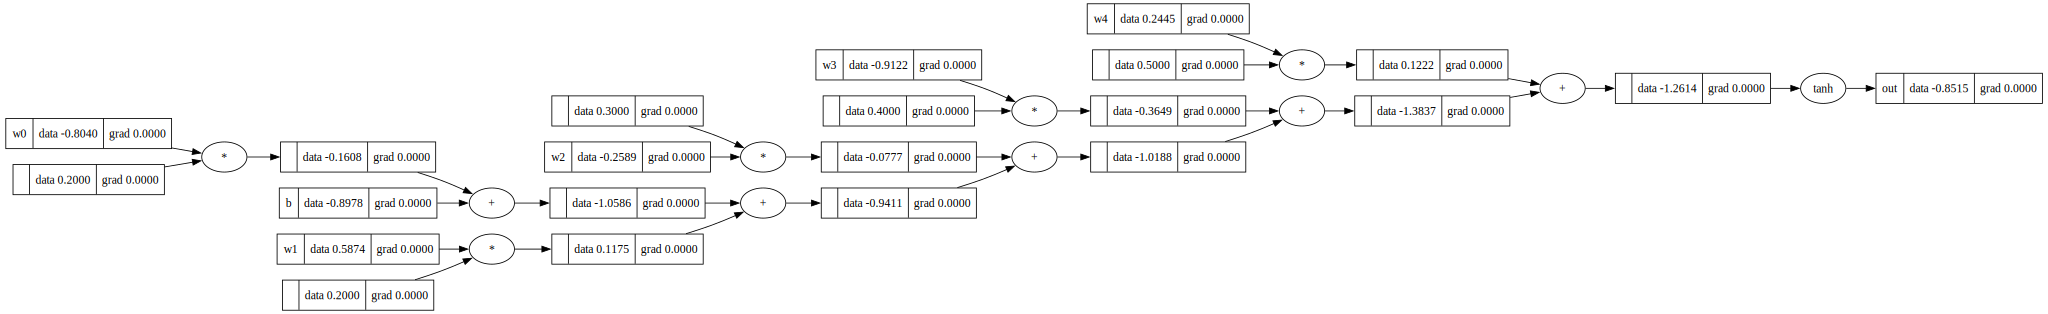

In [25]:
draw_dot(n((0.2,0.2,0.3,0.4,0.5)))

## Couche de neurones

In [26]:
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

In [27]:
l = Layer(2,3)
l((0.2,0.3))


[Value(data=0.3213930604635117, label=out, grad=0.0),
 Value(data=0.31464203078000524, label=out, grad=0.0),
 Value(data=-0.858850222206831, label=out, grad=0.0)]

## Multicouches

In [28]:
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [29]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.5428321376017807, label=out, grad=0.0)

https://cs231n.github.io/neural-networks-1/

![MLP](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

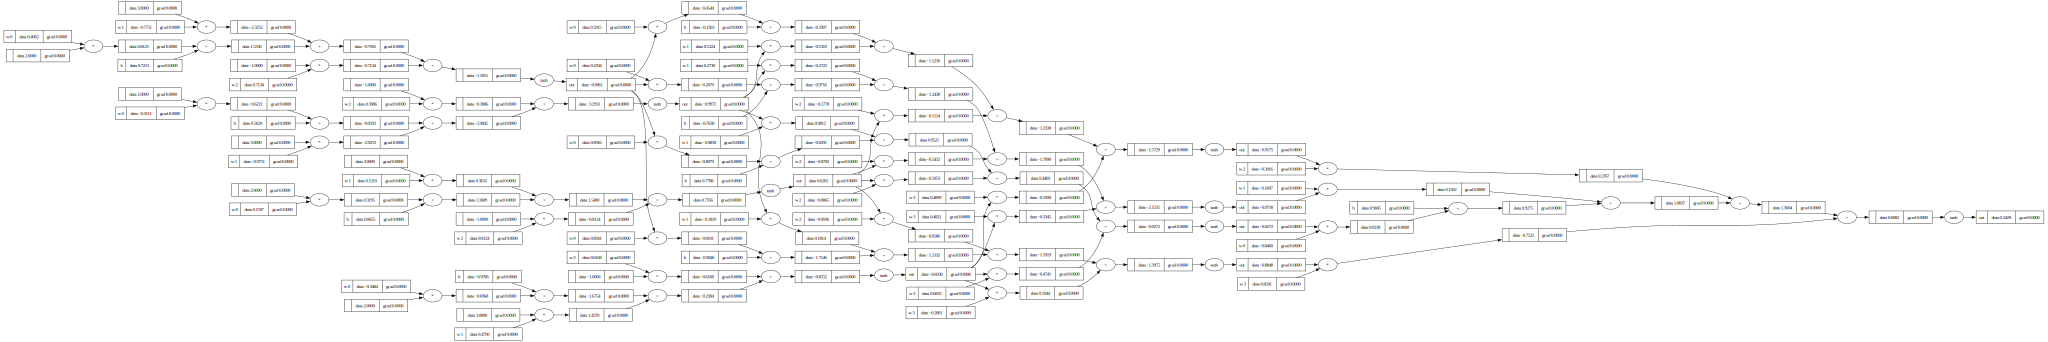

In [30]:
draw_dot(n(x))

# Apprentissage

## Définition d'une fonction de perte

In [31]:
# Jeu d'entrainement
xs = [
    [2.0, 3.0, -1.0],  # exemple 1
    [3.0, -1.0, 0.5],  # exemple 2
    [0.5, 1.0, 1.0],   # exemple 3
    [1.0, 1.0, -1.0],  # exemple 4
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]  # sortie 
ypred

[Value(data=0.5428321376017807, label=out, grad=0.0),
 Value(data=0.8825476224698201, label=out, grad=0.0),
 Value(data=0.24590509211930503, label=out, grad=0.0),
 Value(data=0.4050940086029426, label=out, grad=0.0)]

À ce stade, les valeurs de sortie du réseau ne sont pas bonnes, ce qui est normal car nous n'avons réglé aucun paramètre.
Nous allons définir une fonction que nous allons chercher à optimiser, ici à minimiser: une fonction de perte utilisant l'erreur quadratique moyenne.

In [32]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=0.20900245440975715, label=, grad=0.0),
 Value(data=3.5439855508667724, label=, grad=0.0),
 Value(data=1.5522794985688142, label=, grad=0.0),
 Value(data=0.3539131386001157, label=, grad=0.0)]

In [33]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.65918064244546, label=, grad=0.0)

C'est cette valeur que l'on va chercher à minimiser.

## Reprise des étapes: apprentissage manuel

In [45]:
# Architecture de notre réseau
n = MLP(3, [4, 4, 1])

# Données exemple
xs = [
    [2.0, 3.0, -1.0],  # exemple 1
    [3.0, -1.0, 0.5],  # exemple 2
    [0.5, 1.0, 1.0],   # exemple 3
    [1.0, 1.0, -1.0],  # exemple 4
]

# Cible
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [46]:
# forward pass
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

# backward pass
for p in n.parameters():
    p.grad = 0.0
loss.backward()

# update
for p in n.parameters():
    p.data += -0.1 * p.grad

print(list(map(lambda x: x.data, ypred)))
print(loss.data)

[0.4020920928583902, -0.1894861802920144, -0.05922087190814421, 0.2550894154311267]
2.4543836642161017


## Automatisation de l'apprentissage

In [49]:
for k in range(100):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(f"{k} loss={loss.data} {list(map(lambda x: x.data, ypred))}")

0 loss=0.00027815740115110454 [0.9947032216496835, -0.9913560575993751, -0.9900334740555171, 0.9912792110086672]
1 loss=0.0002778910086773501 [0.9947058577753756, -0.9913601868709156, -0.9900382219334123, 0.9912833679881876]
2 loss=0.0002776251162239342 [0.9947084901418856, -0.9913643103734111, -0.9900429631794665, 0.991287519178031]
3 loss=0.0002773597223959083 [0.9947111187580135, -0.9913684281201739, -0.9900476978089977, 0.9912916645915285]
4 loss=0.00027709482580351365 [0.9947137436325303, -0.9913725401244734, -0.990052425837274, 0.9912958042419678]
5 loss=0.0002768304250621039 [0.9947163647741786, -0.9913766463995367, -0.9900571472795149, 0.9912999381425945]
6 loss=0.0002765665187921489 [0.9947189821916727, -0.9913807469585485, -0.9900618621508906, 0.9913040663066116]
7 loss=0.00027630310561922066 [0.9947215958936985, -0.9913848418146511, -0.9900665704665226, 0.9913081887471796]
8 loss=0.00027604018417393545 [0.9947242058889137, -0.9913889309809447, -0.9900712722414844, 0.99131230